In [125]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import pandas as pd # type: ignore
import matplotlib.pyplot as plt # type: ignore

import sys
import os
sys.path.append(os.path.abspath('../../..'))  # Adjust path as needed

from ds_sales_modules import SalesModelData
from ds_sales_modules import TreeBoostedSalesModel
from ds_sales_modules import (XGboostStrategy, LGBMStrategy, CatBoostStrategy)
from ds_sales_modules import SalesVisualization
from ds_sales_modules import LoggerModelsResults
from ds_sales_modules import MultiPeriodPredictStrategy

In [127]:
df = SalesModelData()
df = df.get_data(period=True, translit=True, left_lim='2023-01-01', right_lim='2024-01-31')
print(f'df size: rows {len(df)} columns {len(df.columns)}')

df size: rows 24062 columns 21


In [128]:
VALIDATION_SIZE = 15+1
TEST_SIZE = 15
GAP = 1
# CROSVAL_LIST = [TEST_SIZE+GAP, TEST_SIZE+30+GAP, TEST_SIZE+60+GAP, TEST_SIZE+90+GAP]
# CROSVAL_LIST = [TEST_SIZE+GAP, #1
#                 TEST_SIZE+15+GAP, #2 
#                 TEST_SIZE+30+GAP, #3
#                 TEST_SIZE+45+GAP, #4
#                 TEST_SIZE+60+GAP, #5
#                 TEST_SIZE+75+GAP, #6
#                 TEST_SIZE+90+GAP, #7
#                 TEST_SIZE+105+GAP, #8
#                 TEST_SIZE+120+GAP, #9
#                 TEST_SIZE+135+GAP] #10
CROSVAL_LIST = [TEST_SIZE+GAP, TEST_SIZE+30+GAP]
CHUNKS = len(CROSVAL_LIST)
FEATURES_BLOCKS_QUANTITY_XGBOOST = 1 #cant be more then 7
OPTUNA_TRIALS_XGBOOST = 10
ROLLING_WINDOW = [7, 30, 60]

models_results_logs = LoggerModelsResults()

In [129]:
xgboost_model = TreeBoostedSalesModel(df=df,
                                      model_strategy=XGboostStrategy(),
                                      train_test_split_strategy=MultiPeriodPredictStrategy(rolling_windows=ROLLING_WINDOW), 
                                      num_features_blocks=FEATURES_BLOCKS_QUANTITY_XGBOOST,
                                      logs=models_results_logs)

In [130]:
xgboost_model.main_loop_with_cv(chunks=CHUNKS,
                                validation_size=VALIDATION_SIZE,
                                cv_offset_list=CROSVAL_LIST)

Nothing new to merge


In [131]:
xgboost_model.set_results_table()
xgboost_model.models_results.head(10)

Worst MSE 11197064269963.023
Best  MSE 10200391938169.117
Worst time 0.476 seconds
Best  time 0.443 seconds


,set_data_augmentation,MSE,params_num,fit_time
0,0,1.020039e+13,6,0.443
1,1,1.119706e+13,6,0.476


In [132]:
xgboost_model.select_top_model_vec(top_mse = 3, top_fit_time = 1)
xgboost_model.selected_model_combination

Nothing new to merge


['0']

In [133]:
mse_day, _, _ = xgboost_model._train_tree(data=xgboost_model.selected_data_for_best_model, 
                                          cross_validation=False, 
                                          logs=False, 
                                          validation_size=TEST_SIZE+1, 
                                          params=None)
print(f'MSE default_XGBRegressor day prediction: {mse_day}')

MSE default_XGBRegressor day prediction: 3256081823577.7417


In [134]:
# xgboost_model._manually_set_top_model_vec(['1'])
# xgboost_model._manually_set_top_model_vec(['0'])
# xgboost_model._manually_set_top_model_vec(['0', '0', '0', '0', '1', '1', '0'])
xgboost_model._manually_set_top_model_vec(['0', '0', '1', '0', '1', '1', '0'])

In [135]:
best_params = xgboost_model.start_optuna(data=xgboost_model.selected_data_for_best_model, n_trials=OPTUNA_TRIALS_XGBOOST)

[I 2024-05-09 04:05:42,033] A new study created in memory with name: no-name-ec2de477-8f07-457b-9c42-6e688b4c578a
[I 2024-05-09 04:06:00,748] Trial 0 finished with value: -9954110734334.258 and parameters: {'max_depth': 4, 'learning_rate': 0.09540919796571656, 'n_estimators': 70, 'gamma': 0.1674417241295432, 'subsample': 0.9930775704538911, 'colsample_bytree': 0.9555457676272445, 'reg_alpha': 0.39271285801126643, 'reg_lambda': 0.14135064937019937}. Best is trial 0 with value: -9954110734334.258.
[I 2024-05-09 04:06:39,820] Trial 1 finished with value: -8142841812396.899 and parameters: {'max_depth': 5, 'learning_rate': 0.15653448084842062, 'n_estimators': 200, 'gamma': 0.12025337863933888, 'subsample': 0.9331258541928287, 'colsample_bytree': 0.8905185767009113, 'reg_alpha': 0.4504584176144517, 'reg_lambda': 0.4944761418215612}. Best is trial 1 with value: -8142841812396.899.
[I 2024-05-09 04:06:50,938] Trial 2 finished with value: -9462870953047.725 and parameters: {'max_depth': 3, 'le

Лучшие параметры: {'max_depth': 5, 'learning_rate': 0.15653448084842062, 'n_estimators': 200, 'gamma': 0.12025337863933888, 'subsample': 0.9331258541928287, 'colsample_bytree': 0.8905185767009113, 'reg_alpha': 0.4504584176144517, 'reg_lambda': 0.4944761418215612}
Лучший результат XGB VAL (MSE): 8.14E+12


In [136]:
y_train, y_test, y_pred, mse = xgboost_model.get_best_model_pred_on_test(df=df,
                                                                         test_size=TEST_SIZE+1)

MSE for day prediction with best XGB model: 4772809980696.465


<Axes: >

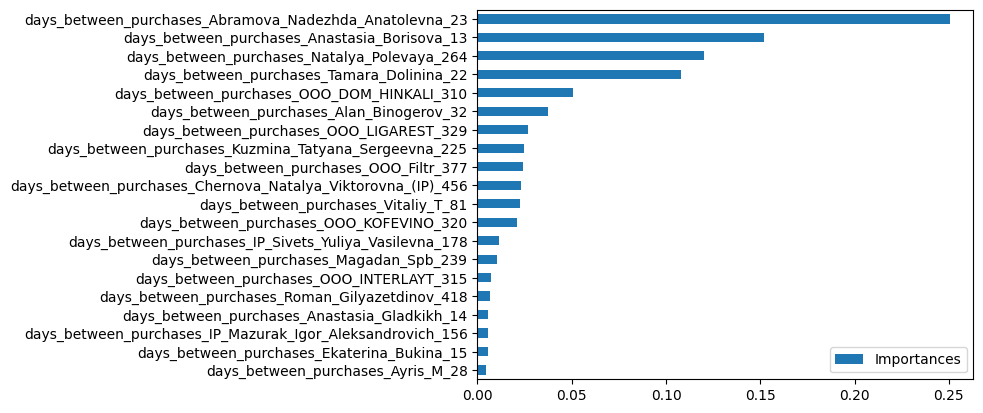

In [137]:
fi = pd.DataFrame(data=xgboost_model.best_cv_model.feature_importances_, index=xgboost_model.best_cv_model.feature_names_in_, columns=['Importances'])
fi.sort_values('Importances', ascending=True)[-20:].plot(kind='barh')

In [138]:
_, margin_of_error = xgboost_model._train_tree(data=xgboost_model.selected_data_for_best_model, 
                                               cross_validation=True, 
                                               chunks=CHUNKS, 
                                               validation_size=VALIDATION_SIZE, 
                                               cv_offset_list = CROSVAL_LIST, 
                                               params=best_params)
lower_bound, upper_bound = xgboost_model.calculate_low_up_bounds(y_pred, margin_of_error, y_test.index)

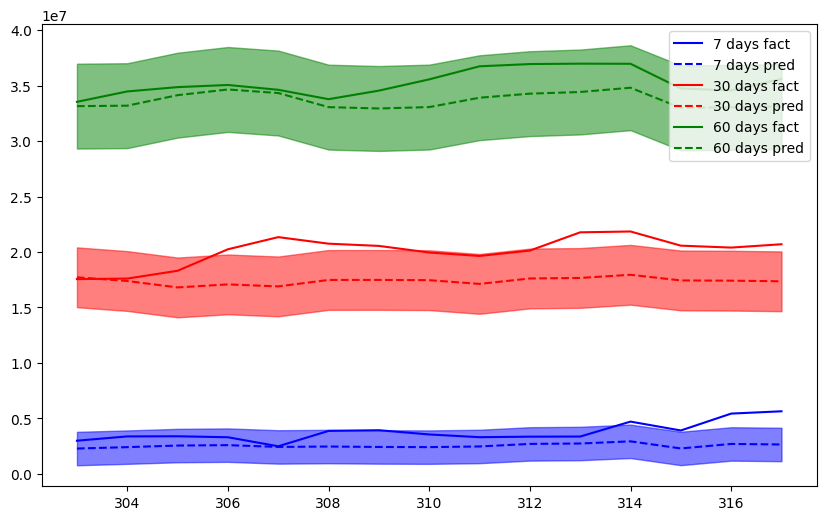

sum_7_days     1.506865e+06
sum_30_days    2.694546e+06
sum_60_days    3.825875e+06
dtype: float64

In [139]:
plt.figure(figsize=(10,6))

colors = ['b', 'r', 'g', 'y']
for i in range(len(y_test.columns)):
    plt.plot(y_test.iloc[:,i],  label=f'{ROLLING_WINDOW[i]} days fact', color=colors[i])
    plt.plot(y_test.index, y_pred[:,i],  label=f'{ROLLING_WINDOW[i]} days pred', color=colors[i], linestyle='--')
    plt.fill_between(y_test.index, lower_bound.iloc[:,i], upper_bound.iloc[:,i], color=colors[i], alpha=0.5)


plt.legend()
plt.show()
margin_of_error.astype(float)

In [140]:
models_results_logs.all_models_parametrs

,MSE_crossval,MSE_test,best_params,features_vec
XGBoost,8.14E+12,4.77E+12,"{'max_depth': 5, 'learning_rate': 0.1565344808...",['0']


In [141]:
lower_bound, upper_bound, margin_of_error = xgboost_model.calculate_confidence_inteval(y_pred, y_test)

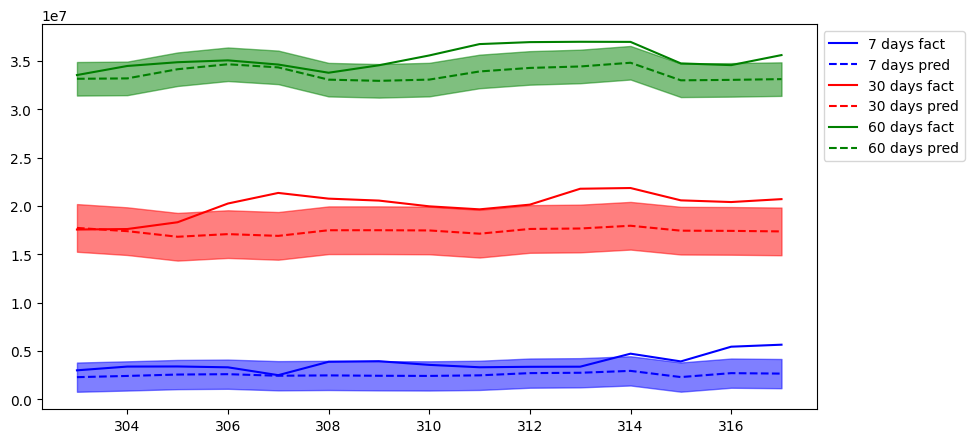

sum_7_days     1.511402e+06
sum_30_days    2.465346e+06
sum_60_days    1.734856e+06
dtype: float64

In [142]:
plt.figure(figsize=(10,5))

colors = ['b', 'r', 'g', 'y']
for i in range(len(y_test.columns)):
    plt.plot(y_test.iloc[:,i],  label=f'{ROLLING_WINDOW[i]} days fact', color=colors[i])
    plt.plot(y_test.index, y_pred[:,i],  label=f'{ROLLING_WINDOW[i]} days pred', color=colors[i], linestyle='--')
    plt.fill_between(y_test.index, lower_bound.iloc[:,i], upper_bound.iloc[:,i], color=colors[i], alpha=0.5)


plt.legend(bbox_to_anchor=(1, 1), loc='upper left', ncol=1)
plt.show()
margin_of_error.astype(float)

margin - take the biggest value
-----------------------------